In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle
import ast
import math 
import traceback

import seaborn as sns

In [3]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [84]:
y.shape

(6499,)

In [85]:
ytest.shape

(1625,)

In [86]:
Xtest.shape

(1625, 6499)

In [87]:
X.shape

(6499, 6499)

In [13]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

In [16]:
from sklearn import datasets
dataset = datasets.fetch_openml("mnist_784", cache=True, as_frame=False)

/Users/niek/niek-env/lib/python3.11/site-packages/sklearn/datasets/_openml.py:65: RuntimeWarning: Invalid cache, redownloading file
  warn("Invalid cache, redownloading file", RuntimeWarning)
/Users/niek/niek-env/lib/python3.11/site-packages/sklearn/datasets/_openml.py:100: UserWarning: A network error occurred while downloading https://openml.org/data/v1/download/52667. Retrying...
  warn(


KeyboardInterrupt: 

In [512]:
from sklearn import model_selection

In [513]:
x = dataset["data"] / 255
y = dataset["target"]

In [514]:
is_3_or_5 = (y == "3") | (y == "5")

In [515]:
x = x[is_3_or_5]
y = y[is_3_or_5]

In [516]:
y = np.array([1 if elem == "5" else 0 for elem in y])

In [517]:
X, Xtest, y, ytest = model_selection.train_test_split(x, y)

In [584]:
y.mean()

0.4724479682854311

## Specify learning algorithms

In [606]:
import math


def sigmoid(x):
    x = np.clip(x, -200, 200)
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    #print(y)
    y = sigmoid(y)
    return y


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def cross_entropy(p, y, epsilon=1e-45):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def log_ratio(u):
    if u <= 10:
        y = ((1 + np.exp(u)) ** 2) * np.log1p(np.exp(-u))
        log_y = np.log(y)
    else:
        log_y = u
    return log_y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    return newtheta

In [651]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=0,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
    epsilon = 1e-45,
    max_iterations = 150000
):
    theta = np.zeros(X.shape[1])
    stheta = theta

    n_iterations = min(X.shape[0], max_iterations)  # Number of iterations
    #thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_reg = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    losses_test_reg = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    #Delta = np.zeros(n_iterations)
    #sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        if mode == "random":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "polyak_absloss":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=0, a_max=1)
            grad = zeta * grad / pz
        elif mode == "polyak_exponent": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            #zeta = kappa * (ratio(u) / (np.linalg.norm(xx) ** 2))
            zeta_log = math.log(kappa) + log_ratio(u) - math.log(np.linalg.norm(xx) ** 2)
            #zeta = math.exp(zeta_log)
            #zeta = min(zeta, kappa0)
            zeta = math.exp(min(zeta_log, math.log(kappa0)))
            pz = zeta ** polyakexp
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak_exponent_old": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = omega * pz
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = backward(xx, yy, p)
        elif mode == "minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        pz = np.clip(pz, epsilon, 1-epsilon)
        z = np.random.binomial(1, pz)
        #print(f"{p=}")
        #print(f"{yy=}")
        losses[i] = loss(p, yy)
        losses_reg[i] = losses[i] + lam * np.linalg.norm(theta)
        
        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        #print(f"{p=}")
        #print(f"{ytest=}")
        losses_test[i] = loss(p, ytest)
        losses_test_reg[i] = losses_test[i] + lam * np.linalg.norm(theta)
        accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 200 == 0:
            print(f"loss: {losses_test[i]}, train loss: {losses[i]}, ||theta||_1: {np.sum(np.abs(theta))} acc: {accuracies[i]}")

    return {
        "losses": losses.tolist(),
        "losses_reg": losses_reg.tolist(),
        "losses_test": losses_test.tolist(),
        "losses_test_reg": losses_test_reg.tolist(),
        "labeled": labeled.tolist(),
        "theta": theta.tolist(),
        #"stheta": stheta,
        "probs": probs.tolist(),
        "accuracies": accuracies.tolist(),
        "accuracies_test": accuracies_test.tolist(),
        #"samples": samples.tolist(),
        #"thetas": thetas.tolist(),
    }

## Use best hyperparams to construct plot
We have stored results from our hyperparameter tuning run. Here we load the results file, and will use the best hyperparameters per method.

In [652]:
hyperparam_results = pd.read_csv("hyperparams_train_loss_zero_init_noreg_target050_eta300.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [653]:
# Calculate best hyperparameters per method
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [654]:
hyperparam_per_algo["absloss"] = {"eta": 0.1}
hyperparam_per_algo["random"] = {"eta": 0.1}
hyperparam_per_algo["polyak_absloss"] |= {
    "eta": 0.1,
    "kappa": 10,
    "kappa0": 0.99,
    "omega": 1.1
}
hyperparam_per_algo["polyak_exponent"] |= {
    "eta": 0.1,
    "kappa": 10,
    "kappa0": 0.99,
    "omega": 1.1
}

In [655]:
hyperparam_per_algo

{'polyak_absloss': {'kappa': 10, 'kappa0': 0.99, 'eta': 0.1, 'omega': 1.1},
 'polyak_exponent': {'kappa': 10,
  'kappa0': 0.99,
  'eta': 0.1,
  'polyakexp': 0.9951814804061615,
  'omega': 1.1},
 'absloss': {'eta': 0.1},
 'random': {'eta': 0.1}}

# Plot 0: train loss of rand vs absloss (first run for absloss, then run for rand for matching pz)

- mean train loss curve
- mean test loss curve
- accuracy

In [656]:
absloss_params = hyperparam_per_algo["absloss"]

results_absloss = train_model(
    X, y, Xtest, ytest, mode="absloss", **absloss_params
)

Training with algorithm absloss: 10090 iterations with d=784
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.30346129846555964, train loss: 0.00022601922263657461, ||theta||_1: 53.47318109360222 acc: 1.0
loss: 0.41132532421864026, train loss: 0.7088665823642771, ||theta||_1: 69.96395454015075 acc: 0.0
loss: 0.2670949874797078, train loss: 0.00010914030340514242, ||theta||_1: 79.6282079340341 acc: 1.0
loss: 0.31296822638118066, train loss: 1.3820124321255242e-06, ||theta||_1: 91.50000346728943 acc: 1.0
loss: 0.25876371581250524, train loss: 0.04562211303754936, ||theta||_1: 95.48964952671754 acc: 1.0
loss: 0.19279192483298604, train loss: 0.006145815593435489, ||theta||_1: 98.38881306257585 acc: 1.0
loss: 0.22826897573446978, train loss: 0.0006902465117181553, ||theta||_1: 101.7072992175983 acc: 1.0
loss: 0.17342248260617762, train loss: 0.002676443870098247, ||theta||_1: 108.8448392212515 acc: 1.0
loss: 0.2570413091156138, train loss: 1.59660

In [657]:
absloss_mean_sampling_prob = np.mean(results_absloss["probs"])

In [658]:
absloss_mean_sampling_prob

0.0954952342024728

In [659]:
rand_params = hyperparam_per_algo["random"]

results_rand = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(rand_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 10090 iterations with d=784
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 1.1655581947013214, train loss: 0.01346106959851202, ||theta||_1: 29.59733881029207 acc: 1.0
loss: 0.42228027367633253, train loss: 1.0880141966765258, ||theta||_1: 34.435984868584114 acc: 0.0
loss: 0.3577125980568702, train loss: 0.015092962027130544, ||theta||_1: 37.50039470480614 acc: 1.0
loss: 0.8068528941960169, train loss: 1.074588695553777, ||theta||_1: 50.06460807145704 acc: 0.0
loss: 0.2825038446398276, train loss: 0.012704088197563572, ||theta||_1: 51.386616312184856 acc: 1.0
loss: 0.29698520344058815, train loss: 0.006101598774000477, ||theta||_1: 56.98786902744549 acc: 1.0
loss: 0.3773973403095927, train loss: 0.0006663778315095579, ||theta||_1: 57.33466952277858 acc: 1.0
loss: 0.29311220431180773, train loss: 0.005801004504213775, ||theta||_1: 60.89608056124723 acc: 1.0
loss: 0.27662095435900536, train loss: 2.704513447522916

In [660]:
results_rand_absloss_params = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(absloss_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 10090 iterations with d=784
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.43615572714071593, train loss: 0.021046186120971894, ||theta||_1: 28.3050126447513 acc: 1.0
loss: 0.32399431170214915, train loss: 0.031171532953651042, ||theta||_1: 35.71398983307237 acc: 1.0
loss: 0.3925020387274351, train loss: 0.017790568766573724, ||theta||_1: 42.890734778479576 acc: 1.0
loss: 0.33521492806319364, train loss: 0.009523030783957841, ||theta||_1: 51.37912782115913 acc: 1.0
loss: 0.2906165327711654, train loss: 0.01798152672340297, ||theta||_1: 53.14242867238765 acc: 1.0
loss: 0.2850342262455427, train loss: 0.004028967733365211, ||theta||_1: 55.233914813410166 acc: 1.0
loss: 0.36172158554923955, train loss: 0.060235335746571673, ||theta||_1: 59.70672675605618 acc: 1.0
loss: 0.24953877763949817, train loss: 0.15244655609856758, ||theta||_1: 63.47876828150856 acc: 1.0
loss: 0.2772666949997207, train loss: 1.441490226153

In [661]:
results_absloss_rand_params = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **rand_params
)

Training with algorithm absloss: 10090 iterations with d=784
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.2600938388464959, train loss: 0.011010406871204713, ||theta||_1: 52.14264108436903 acc: 1.0
loss: 0.22286688313371403, train loss: 1.5526749869166556, ||theta||_1: 64.68146324929438 acc: 0.0
loss: 0.2675560428900845, train loss: 0.002182484497675976, ||theta||_1: 79.81737145181503 acc: 1.0
loss: 0.334419477170262, train loss: 9.787676686513325e-05, ||theta||_1: 90.81896392388168 acc: 1.0
loss: 0.4063976122837467, train loss: 0.04064971985588084, ||theta||_1: 94.89925638279598 acc: 1.0
loss: 0.19500656964236518, train loss: 0.013543264609702538, ||theta||_1: 100.45921751001529 acc: 1.0
loss: 0.17995787268251917, train loss: 0.0036776373432014036, ||theta||_1: 105.81344048194592 acc: 1.0
loss: 0.1931048422066761, train loss: 0.0010296293889317692, ||theta||_1: 108.97240717106189 acc: 1.0
loss: 0.2719038309287348, train loss: 2.2045276397

In [662]:
def results_to_df(results):
    dfs = []
    for k, v in results.items():
        df = pd.DataFrame(
            {
                "train_loss": v["losses"],
                "train_loss_reg": v["losses_reg"],
                "test_loss": v["losses_test"],
                "test_loss_reg": v["losses_test_reg"],
                "iteration": range(1, len(v["losses"]) + 1),
                "labeled": v["labeled"],
                "probs": v["probs"],
                "train_accuracy": v["accuracies"],
                "test_accuracy": v["accuracies_test"],
            }
        )
        df["method"] = k
        df["mean_train_loss"] = np.cumsum(df.train_loss) / df.iteration
        df["mean_test_loss"] = np.cumsum(df.test_loss) / df.iteration
        df["mean_test_accuracy"] = np.cumsum(df.test_accuracy) / df.iteration
        df["mean_train_accuracy"] = np.cumsum(df.train_accuracy) / df.iteration
        df["cost"] = np.cumsum(df.labeled)
        dfs += [df]   
    
    return pd.concat(dfs, axis=0)

results_df = results_to_df(
    {
        "absloss": results_absloss,
        "random": results_rand,
        "random_with_absloss_params": results_rand_absloss_params,
        "absloss_with_random_params": results_absloss_rand_params,
    }
)

(0.0, 1000.0)

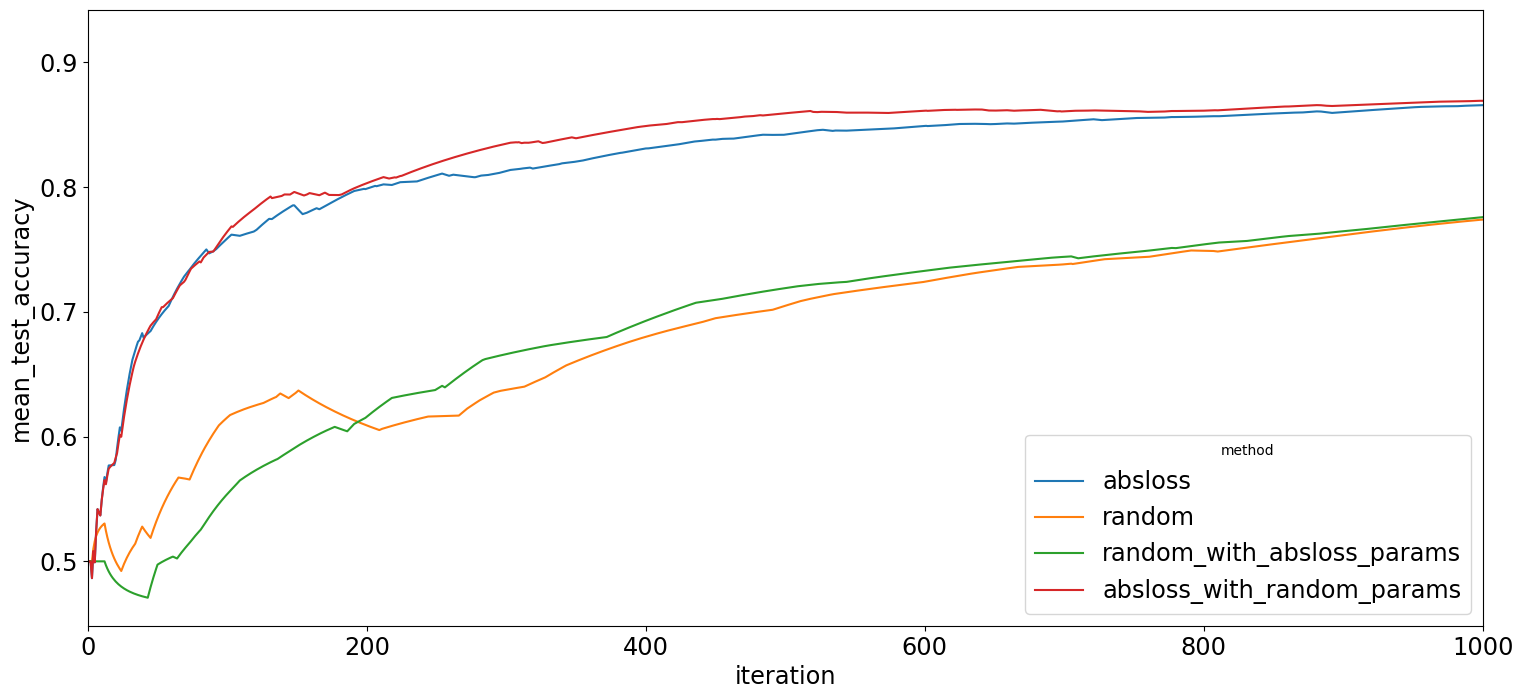

In [663]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df,#results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

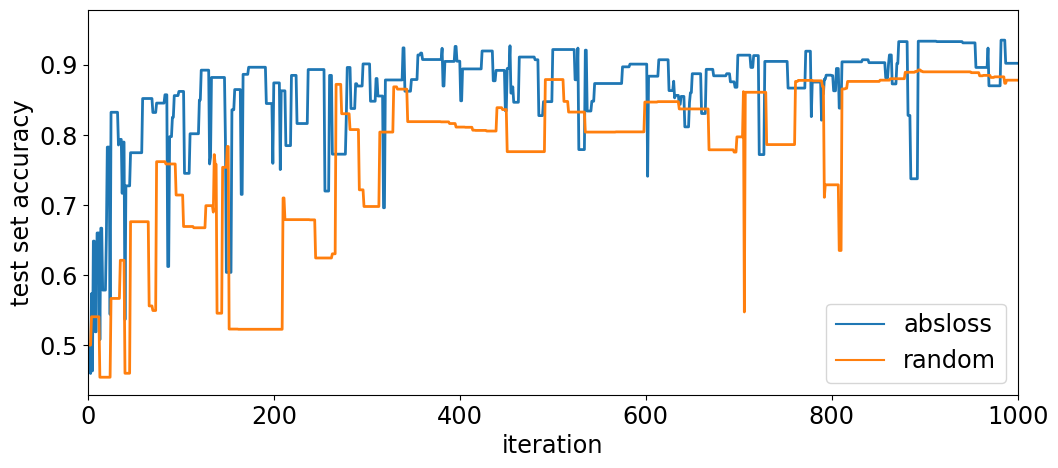

In [664]:
plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="test_accuracy",
    hue="method",
    linewidth=2
)

legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="test set accuracy")
sns.move_legend(ax, "lower right")

ax.set_xlim((0, 1000))

plt.savefig("figure_8a_icml_mnist.pdf", format="pdf", bbox_inches="tight")

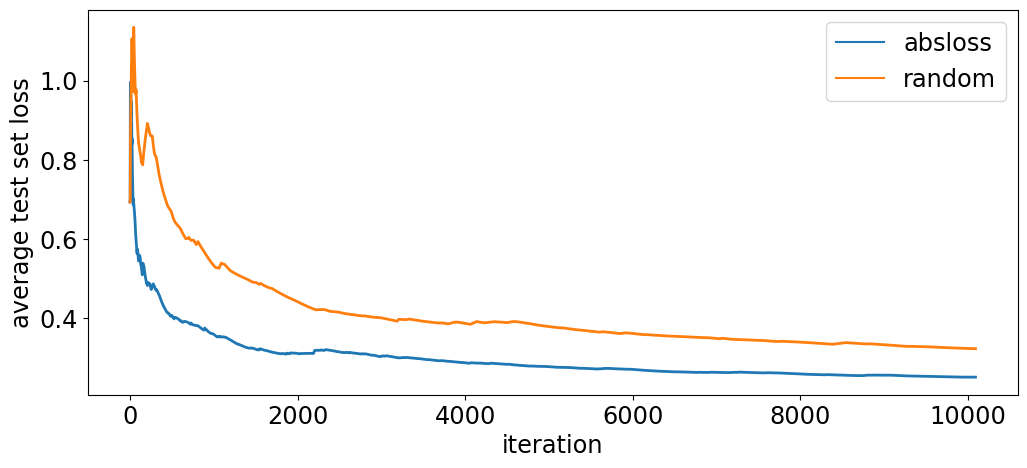

In [665]:
plt.figure(figsize=(12,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_loss",
    hue="method",
    linewidth=2
)
ax.set(ylabel="average test set loss")
legend = ax.get_legend()
legend.set_title('')

plt.savefig("figure_7a_icml_mnist.pdf", format="pdf", bbox_inches="tight")

Text(0, 0.5, 'average cross entropy loss')

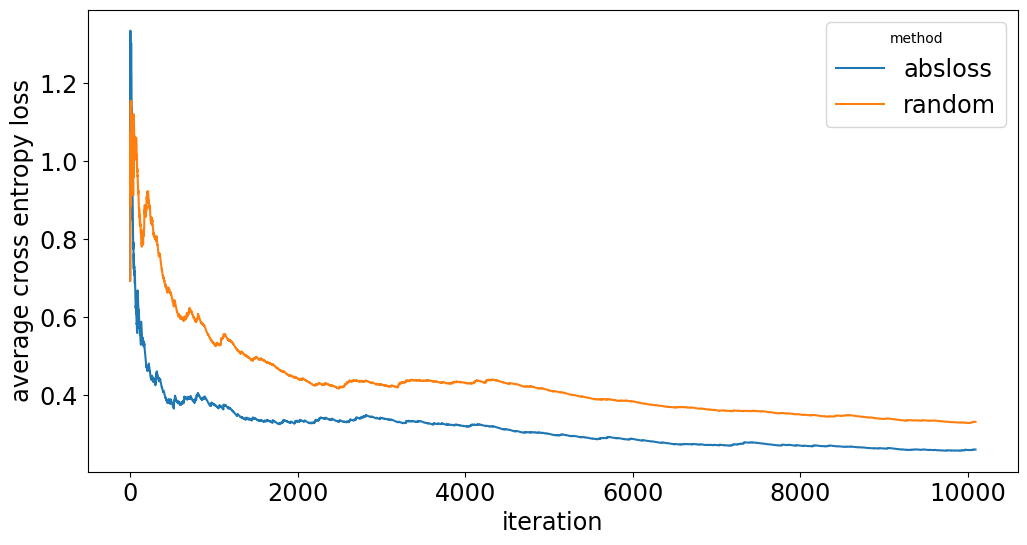

In [666]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

#plt.xscale('log')
#plt.yscale('log')

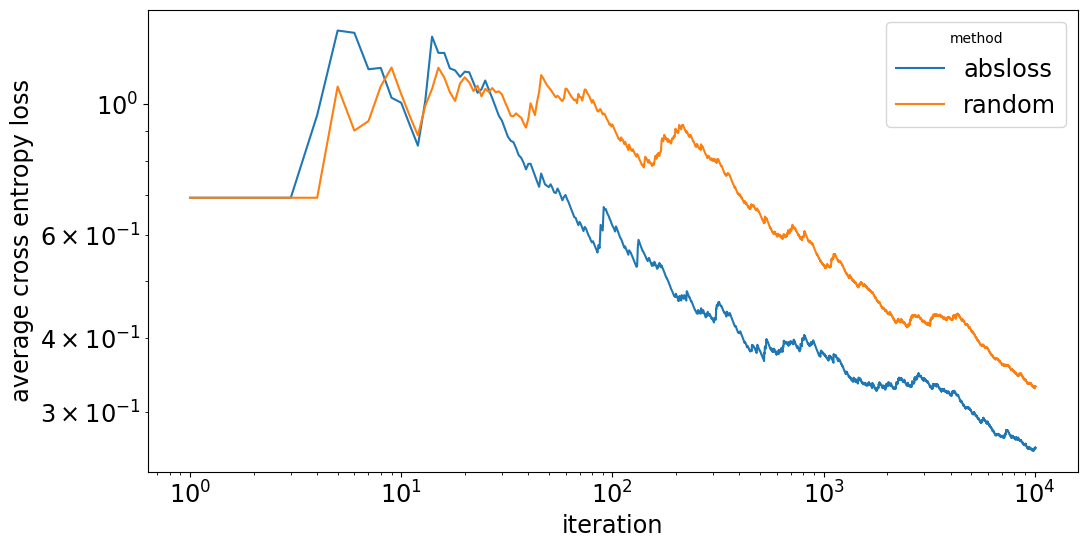

In [667]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

plt.xscale('log')
plt.yscale('log')

# Plot 1: train loss of rand vs Polyak exponent 
First run for various Polyak exponent values, and the run for rand for matching pz

- mean train loss curve
- mean test loss curve
- accuracy

For a single instance, polyak exponent method does:

pz = zeta ** polyakexponent

We aim to control the mean of pz across the dataset. 
we can find approximate solutions by taking zeta to be constant.

mean_pz = c ** polyakexponent

We don't know what c is because it depends on kappa, kappa0, 
and the losses in complex ways. However,  Then we can run the training loop
with polyakexp = 1 and take the empirical mean of the pz values to find our estimate for c.

Now we can find estimates of the polyakexp values that will lead to any desired mean_pz a using:

a = c ** polyakexp
log(a) = log(c ** ployakexp)
log(a) = ployakexp * log(c)
polyakexp = log(a) / log(c)

In practice, c is not a constant, but we instead have an instance-specific zeta.
As a result, it is likely that when we use this to derive this equation that gives us a value of polyakexp
for a desired sampling probability a, that the empirical mean sampling probability somewhat deviates that.

This is OK, since we're not looking to control pz precisely. Rather, we are looking to verify that polyak exponent
is more efficient than random sampling even in scenarios where we sample. We are simply looking to cover a wide range
of sampling probabilities.

To achieve a fair comparison against random sampling, we will calculate the empirical pz of the polyak exponent runs under a
and then run a random sampling under the same probability.

In [668]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyakexp_1_results = train_model(
    X, y, Xtest, ytest, mode="polyak_exponent", **(polyak_exponent_params | {"polyakexp": 1})
)

c = np.mean(polyakexp_1_results["probs"])

Training with algorithm polyak_exponent: 10090 iterations with d=784
loss: 1.1783003210665588, train loss: 0.6931471805599453, ||theta||_1: 5.84235294117647 acc: 0.5
loss: 0.20902817255070197, train loss: 0.0012507097738717193, ||theta||_1: 43.718339774547516 acc: 1.0
loss: 0.25956044838779607, train loss: 0.2177095413283275, ||theta||_1: 57.10564166423278 acc: 1.0
loss: 0.23074378566911635, train loss: 0.00021345721192361474, ||theta||_1: 73.33102561623778 acc: 1.0
loss: 0.2841106713590886, train loss: 1.730054040544898e-06, ||theta||_1: 80.71748014864981 acc: 1.0
loss: 0.2477682098507266, train loss: 0.07364238377909717, ||theta||_1: 85.36647271144558 acc: 1.0
loss: 0.2396051785101673, train loss: 0.0014913037654632742, ||theta||_1: 91.09781830310757 acc: 1.0
loss: 0.2007563482388764, train loss: 0.0005928587680586309, ||theta||_1: 93.78141365116197 acc: 1.0
loss: 0.19329868182308582, train loss: 0.00036738301885872837, ||theta||_1: 96.84123632447056 acc: 1.0
loss: 0.1981399117566006

In [669]:
# We're aiming to achieve sampling probabilities <0.1, 0.2, ..., 1.0>
#target_pzs = [0.1 * i for i in range(1, 11)]
target_pzs = [0.01, 0.1, 0.25, 0.5]
polyak_exps = [math.log(a) / math.log(c) for a in target_pzs]
polyak_exps

[55.23315294378776, 27.61657647189388, 16.62683579117644, 8.31341789558822]

In [670]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyak_exponent_results = {
    f"polyak_exponent_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="polyak_exponent", verbose=False, **(polyak_exponent_params | {"polyakexp": polyak_exp})
    )
    for polyak_exp in polyak_exps
}

In practice, c is not a constant, but we instead have an instance-specific zeta that depends on kappa, kappa0, and the losses in complex ways.
As a result, it is likely that the empirical mean sampling probabilities somewhat deviate from our targets target_pzs.

We now calculate the empirical pzs of these polyak exponent runs.

In [671]:
empirical_pzs = []
for key in polyak_exponent_results.keys():
    empirical_pzs += [np.mean(polyak_exponent_results[key]["probs"])]

In [672]:
empirical_pzs

[0.3849882384870609,
 0.6338634939002602,
 0.6920363411327299,
 0.7964788584704828]

In [673]:
rand_params = hyperparam_per_algo["random"]

rand_results = {
    f"random_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="random", verbose=False, **(rand_params | {"pz0": empirical_pz})
    )
    for polyak_exp, empirical_pz in zip(polyak_exps, empirical_pzs)
}

In [674]:
plot1_df = results_to_df((rand_results | polyak_exponent_results))
plot1_df[['method', 'polyak_exp']] = plot1_df['method'].str.rsplit('_', n=1, expand=True)

In [675]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).train_loss.mean()

method           polyak_exp  probs       
polyak_exponent  16.6        1.101295e-14    1.747964
                             1.508578e-14    1.491732
                             2.210444e-14    0.693147
                             2.389273e-14    1.479084
                             4.479863e-14    2.333728
                                               ...   
                 8.3         9.198427e-01    3.464612
random           16.6        6.920363e-01    0.252304
                 27.6        6.338635e-01    0.255314
                 55.2        3.849882e-01    0.266195
                 8.3         7.964789e-01    0.245861
Name: train_loss, Length: 8330, dtype: float64

In [676]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).mean_train_loss.min()

method           polyak_exp  probs       
polyak_exponent  16.6        1.101295e-14    1.026282
                             1.508578e-14    1.139282
                             2.210444e-14    0.693147
                             2.389273e-14    1.587291
                             4.479863e-14    1.167650
                                               ...   
                 8.3         9.198427e-01    0.752832
random           16.6        6.920363e-01    0.247794
                 27.6        6.338635e-01    0.251513
                 55.2        3.849882e-01    0.262037
                 8.3         7.964789e-01    0.241092
Name: mean_train_loss, Length: 8330, dtype: float64

Polyak exp value 55.2 has rows (20180, 16)
Polyak exp value 27.6 has rows (20180, 16)
Polyak exp value 16.6 has rows (20180, 16)
Polyak exp value 8.3 has rows (20180, 16)


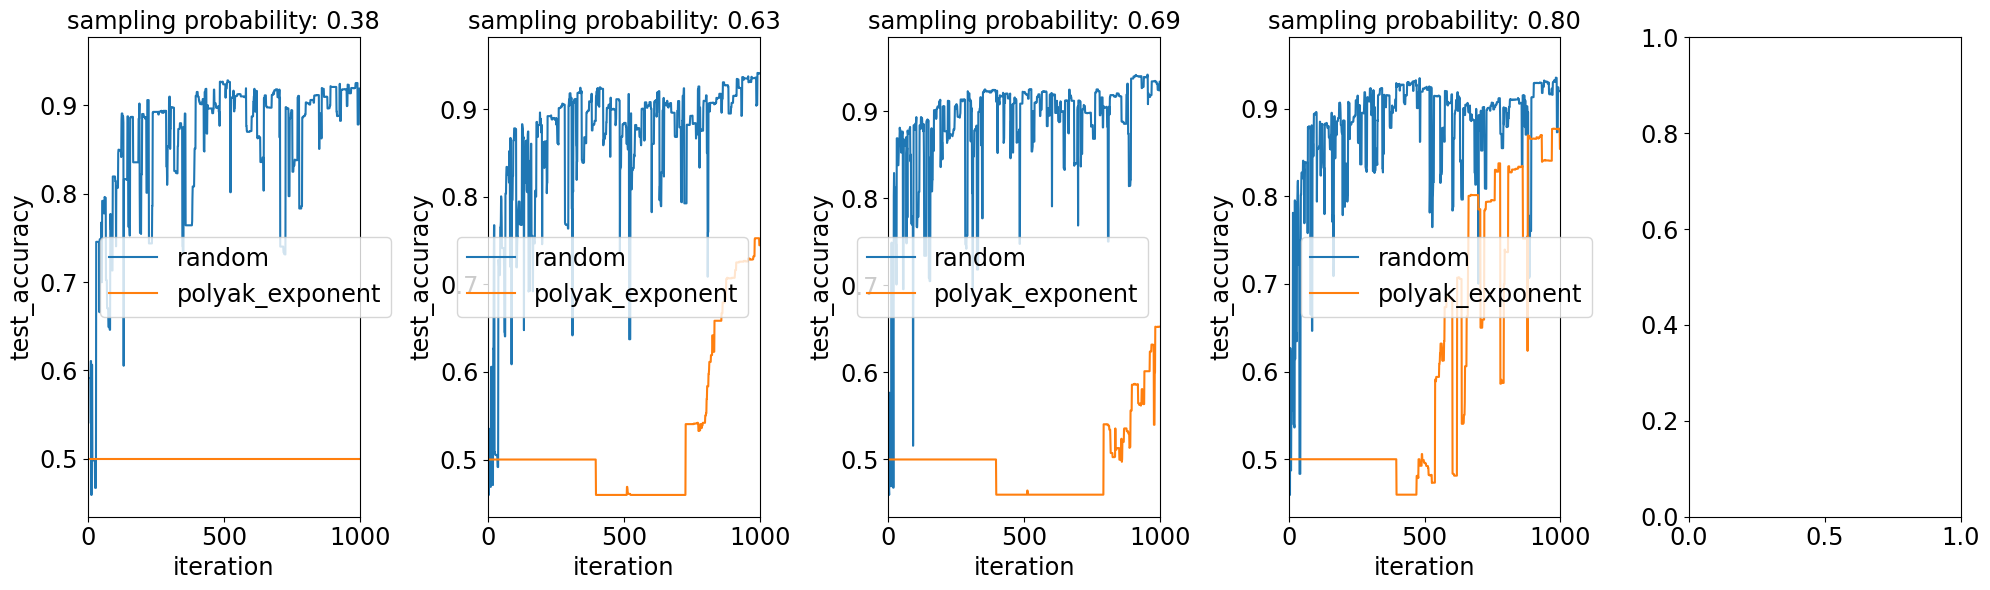

In [677]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]#[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    ax.set_xlim((0, 1000))
    
    i+=1
f.tight_layout()

Polyak exp value 55.2 has rows (20180, 16)
Polyak exp value 27.6 has rows (20180, 16)
Polyak exp value 16.6 has rows (20180, 16)
Polyak exp value 8.3 has rows (20180, 16)


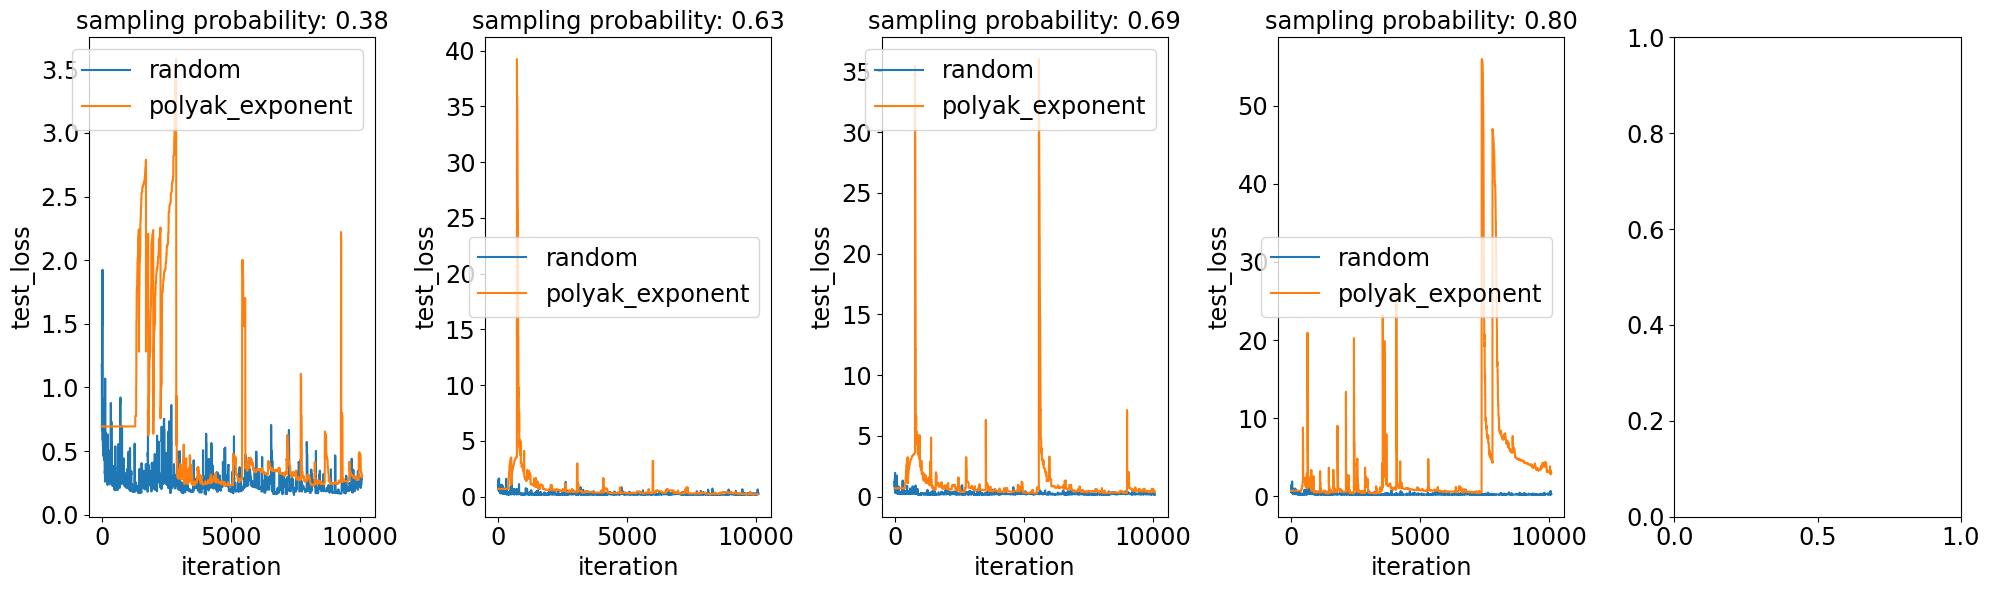

In [678]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    #ax.set_ylim((0.63, 0.7))
    
    i+=1
f.tight_layout()

In [679]:
plot1_df["method"] = [method if method != "polyak_exponent" else "polyak_power_function" for method in plot1_df.method]

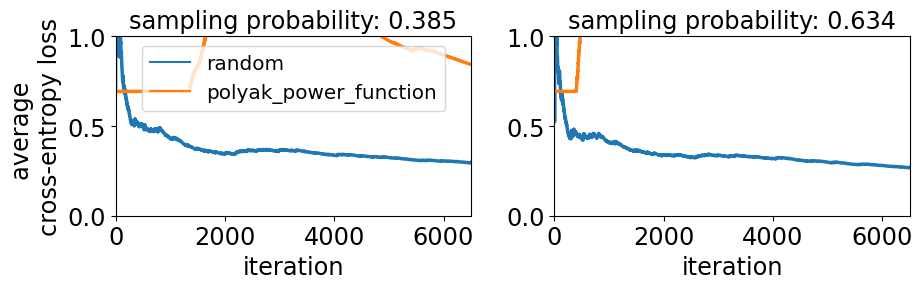

In [680]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.0))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax,
        linewidth=2.5
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 1))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average \ncross-entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig("figure_2_icml_mnist.pdf", format="pdf", bbox_inches="tight")

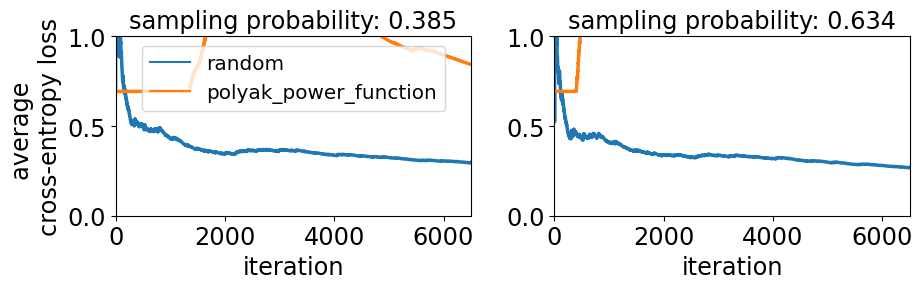

In [681]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.0))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax,
        linewidth=2.5
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 1))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average \ncross-entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig("figure_2_icml_mnist.pdf", format="pdf", bbox_inches="tight")

0.3849882384870609
Polyak exp value 55.2 has rows (20180, 16)
0.6338634939002602
Polyak exp value 27.6 has rows (20180, 16)
0.6920363411327299
Polyak exp value 16.6 has rows (20180, 16)
0.7964788584704828
Polyak exp value 8.3 has rows (20180, 16)


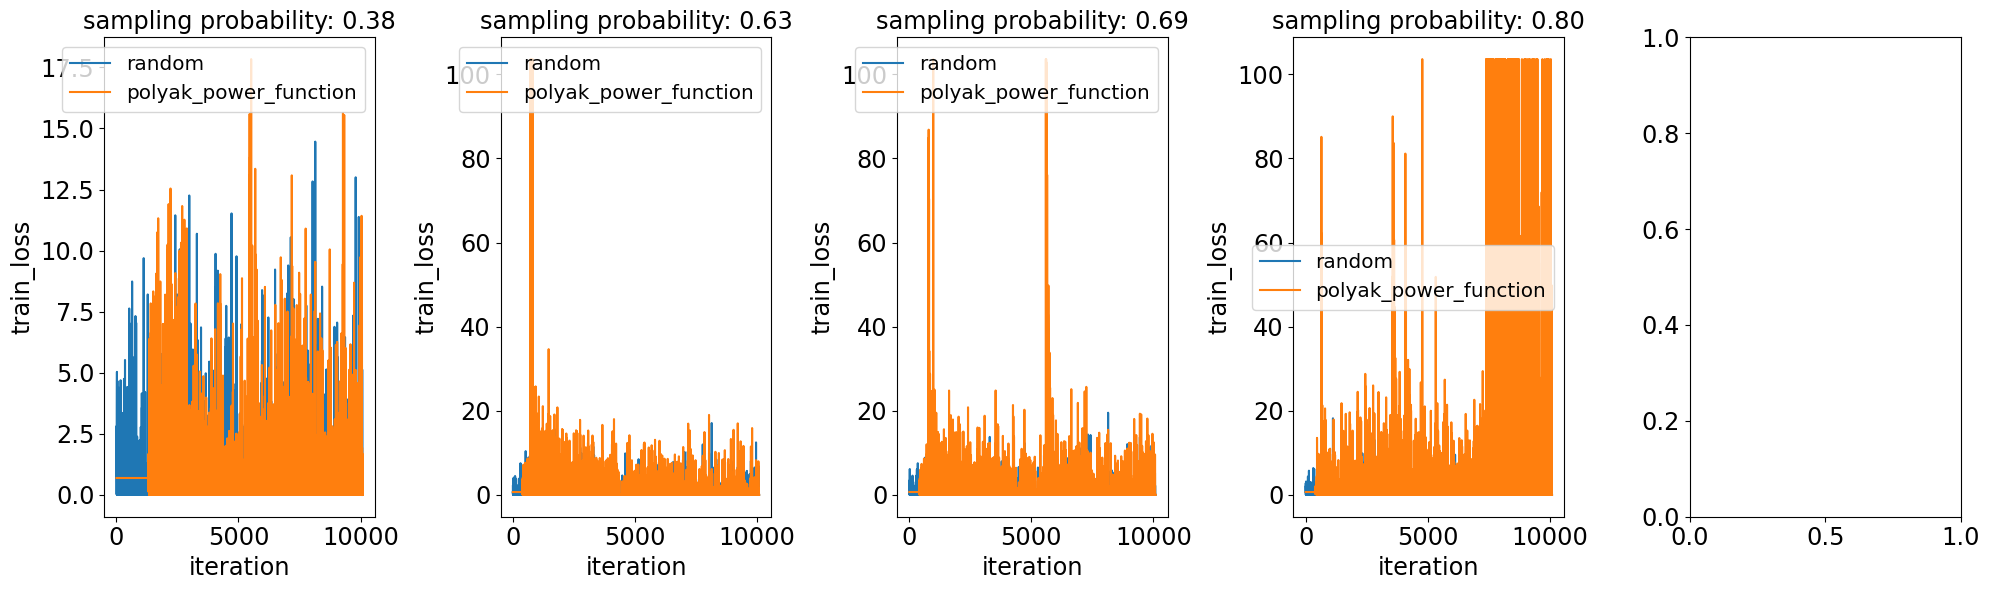

In [682]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    
    i+=1
f.tight_layout()

0.3849882384870609
Polyak exp value 55.2 has rows (20180, 16)
0.6338634939002602
Polyak exp value 27.6 has rows (20180, 16)
0.6920363411327299
Polyak exp value 16.6 has rows (20180, 16)
0.7964788584704828
Polyak exp value 8.3 has rows (20180, 16)


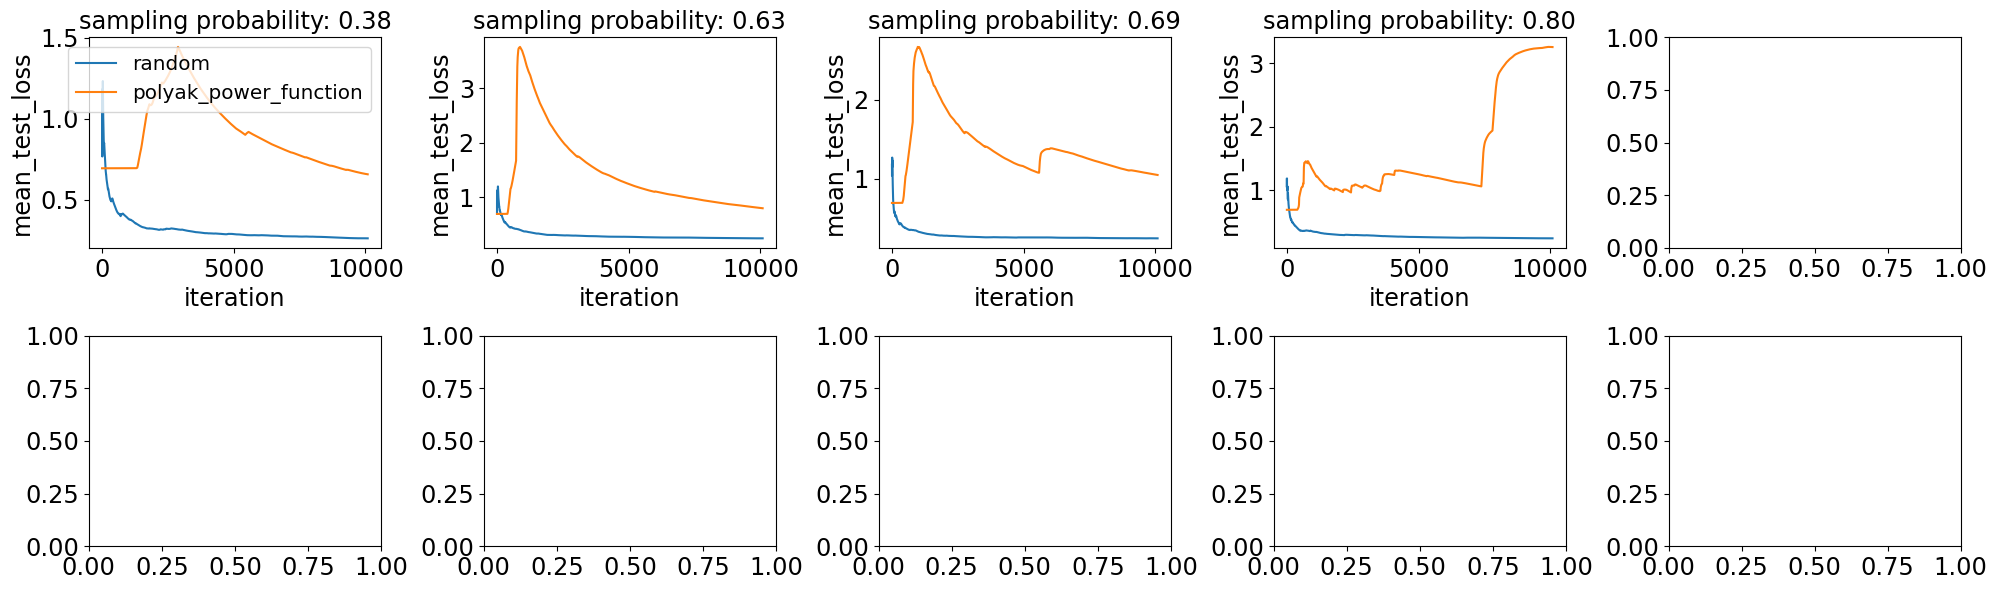

In [683]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
handles, labels = [], []

i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    if i == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    else:
        ax.get_legend().remove()
    
    i+=1
f.tight_layout()

# Plot 2: Polyak absloss vs absloss
First run absloss, then we run Polyak absloss with omega=1 with yields the same sampling probability

- mean train loss curve
- mean test loss curve
- accuracy

In [684]:
hyperparam_per_algo["polyak_absloss"]

{'kappa': 10, 'kappa0': 0.99, 'eta': 0.1, 'omega': 1.1}

In [685]:
results_polyak_absloss = train_model(
    X, y, Xtest, ytest, mode="polyak_absloss", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["polyak_absloss"]
)

Training with algorithm polyak_absloss: 10090 iterations with d=784
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.2609158647193598, train loss: 0.00024914222137511534, ||theta||_1: 42.31677308908327 acc: 1.0
loss: 0.23993268039830545, train loss: 0.06831590062896643, ||theta||_1: 50.650853337777555 acc: 1.0
loss: 0.5479175815039729, train loss: 3.972652883941697e-06, ||theta||_1: 67.85550343150442 acc: 1.0
loss: 0.2298054833323594, train loss: 0.0002537246557614318, ||theta||_1: 78.06397157166012 acc: 1.0
loss: 0.22540562462137048, train loss: 0.0010316192841151085, ||theta||_1: 82.12333794319991 acc: 1.0
loss: 0.17030558291059444, train loss: 0.0005960942146408304, ||theta||_1: 87.68458048001477 acc: 1.0
loss: 0.3510963007181299, train loss: 1.5553140251131643e-05, ||theta||_1: 92.62555764861044 acc: 1.0
loss: 0.3083151463211051, train loss: 0.05722967204140699, ||theta||_1: 98.98911811718446 acc: 1.0
loss: 0.2898499267230608, train loss: 

In [686]:
hppa = hyperparam_per_algo["polyak_absloss"]
hppa["omega"] *= np.mean(results_absloss["probs"]) / np.mean(results_polyak_absloss["probs"])
hyperparam_per_algo["polyak_absloss"] = hppa
print(hppa)

{'kappa': 10, 'kappa0': 0.99, 'eta': 0.1, 'omega': 1.096313465282491}


In [687]:
plot2_df = results_to_df(
    {
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss,
    }
)

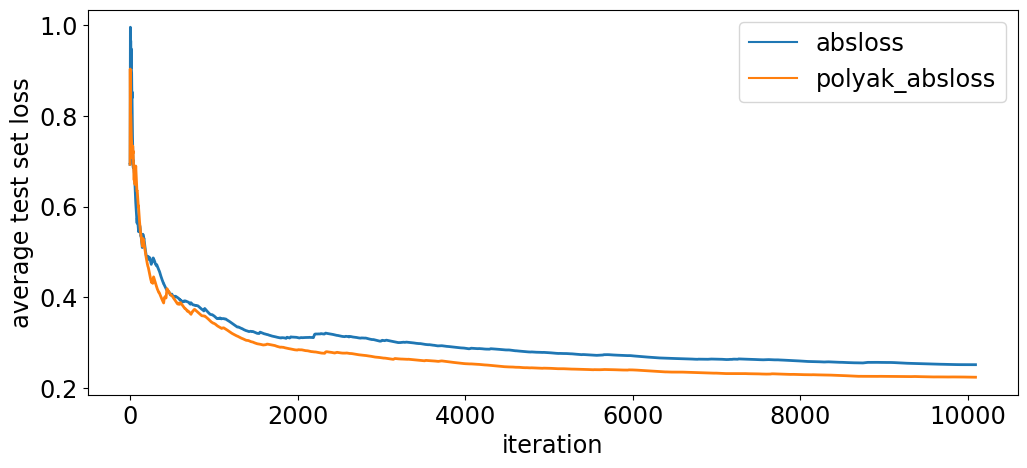

In [688]:
plt.figure(figsize=(12,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_loss",
    hue="method",
    linewidth=2
)

legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="average test set loss")

plt.savefig("figure_7b_icml_mnist.pdf", format="pdf", bbox_inches="tight")

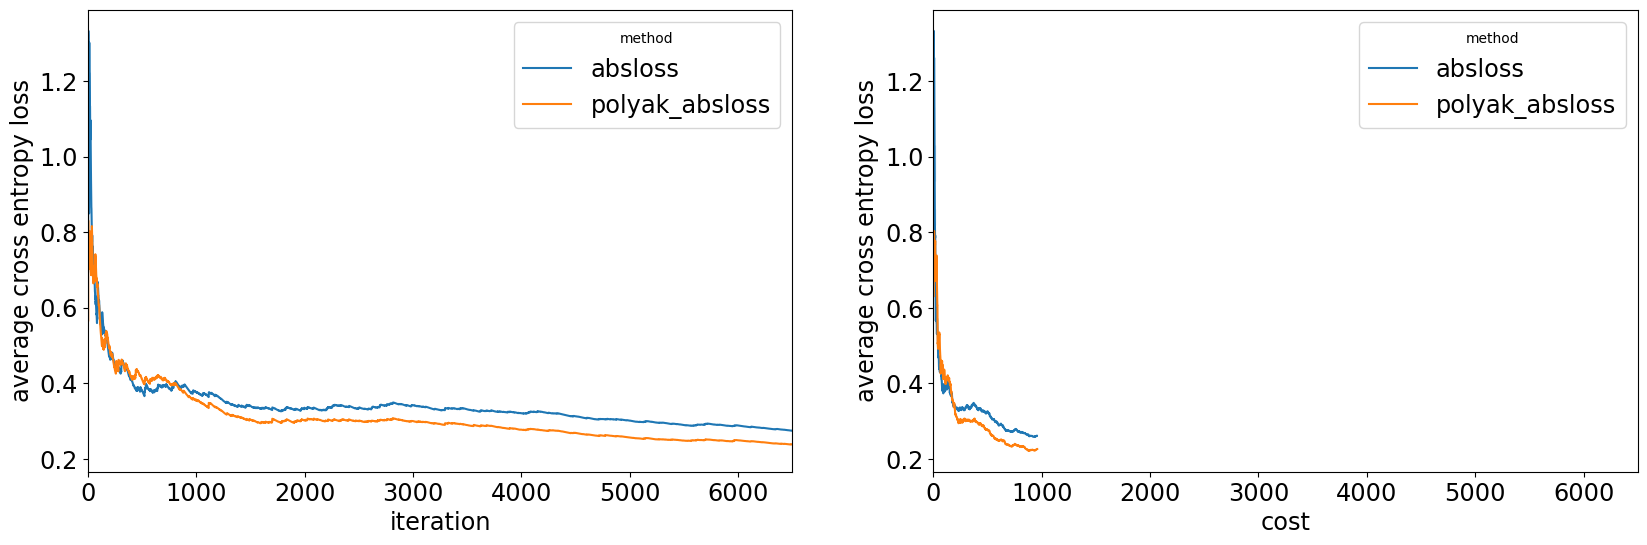

In [689]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot2_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 6499))

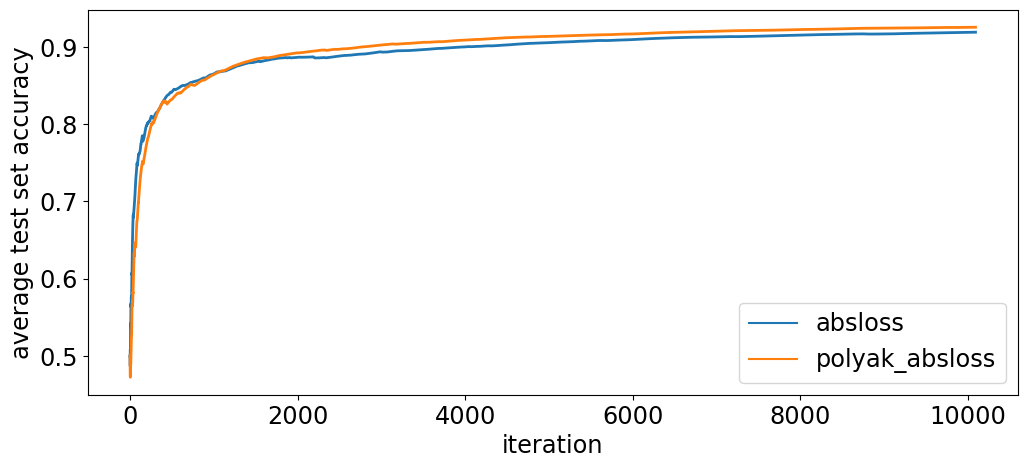

In [690]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_accuracy",
    hue="method",
    linewidth=2
)

ax.set(ylabel="average test set accuracy")

legend = ax.get_legend()
legend.set_title('')

plt.savefig("figure_8b_icml_mnist.pdf", format="pdf", bbox_inches="tight")

In [691]:
plot02_df = results_to_df(
    {
        "random": results_rand,
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss
    }
)

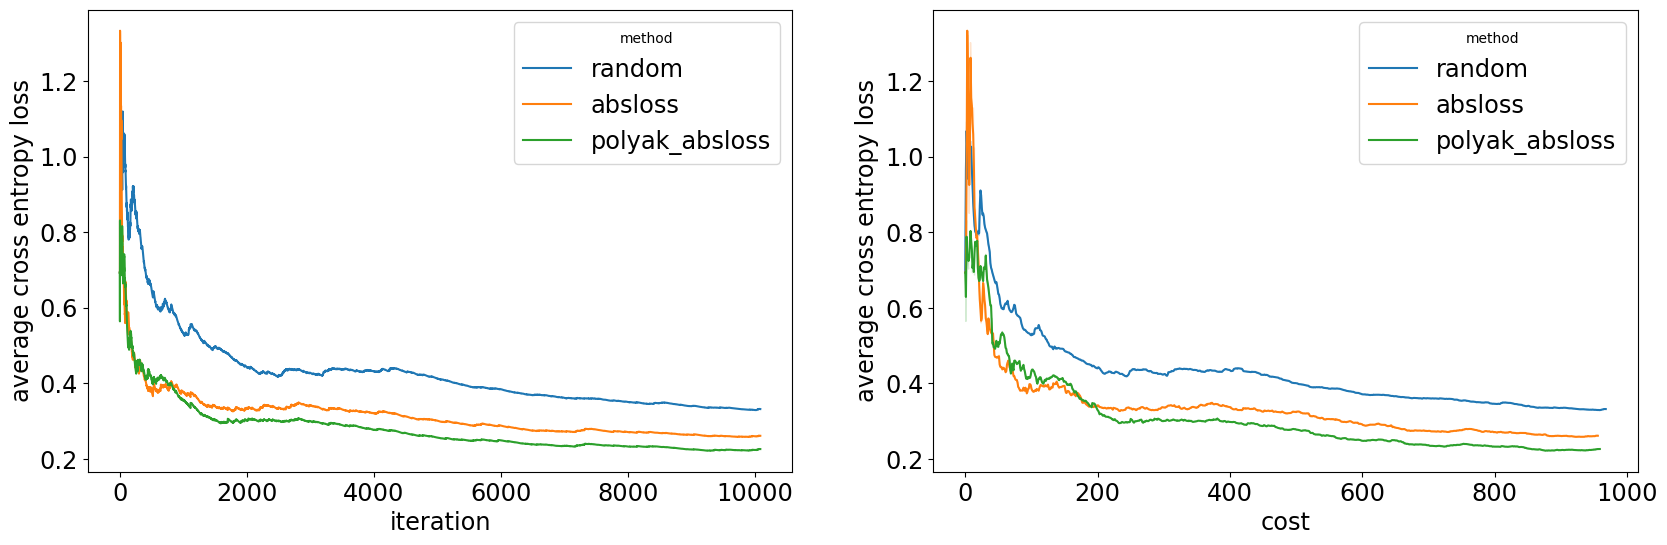

In [692]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")

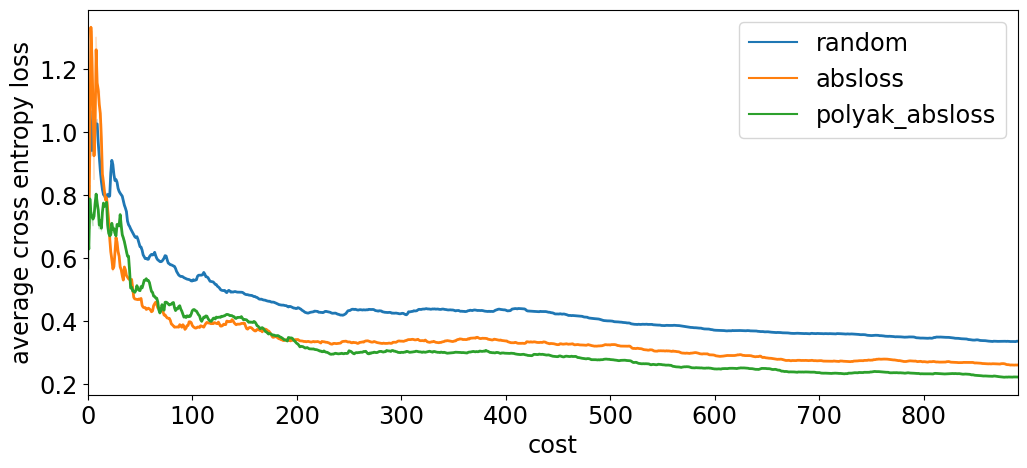

In [693]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    linewidth=2
)

ax.set(ylabel="average cross entropy loss")
ax.set_xlim((0, 890))

legend = ax.get_legend()
legend.set_title('')

plt.savefig("figure_6_icml_mnist.pdf", format="pdf", bbox_inches="tight")

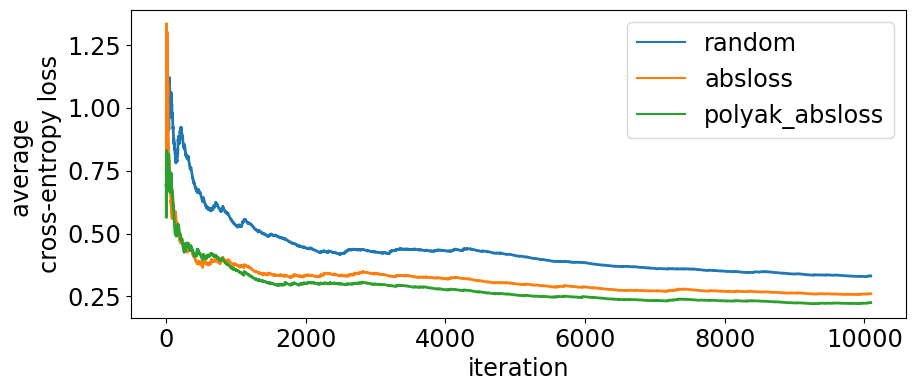

In [694]:
plt.figure(figsize=(10,4))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    linewidth=2
)
legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="average \ncross-entropy loss")

plt.savefig("figure_3_icml_mnist.pdf", format="pdf", bbox_inches="tight")
